# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 12            
model_seed = 2           

# --- Training configuration ---
epochs = 4000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/4000: Train Loss 2.3134 | Test Loss 2.2222 | accs Train 0.1667 Test 0.3035


Epoch 100/4000: Train Loss 0.0001 | Test Loss 1.3637 | accs Train 1.0000 Test 0.6966


Epoch 200/4000: Train Loss 0.0001 | Test Loss 1.3770 | accs Train 1.0000 Test 0.6983


Epoch 300/4000: Train Loss 0.0000 | Test Loss 1.3897 | accs Train 1.0000 Test 0.6999


Epoch 400/4000: Train Loss 0.0000 | Test Loss 1.4020 | accs Train 1.0000 Test 0.7009


Epoch 500/4000: Train Loss 0.0000 | Test Loss 1.4131 | accs Train 1.0000 Test 0.7020


Epoch 600/4000: Train Loss 0.0000 | Test Loss 1.4234 | accs Train 1.0000 Test 0.7029


Epoch 700/4000: Train Loss 0.0000 | Test Loss 1.4328 | accs Train 1.0000 Test 0.7026


Epoch 800/4000: Train Loss 0.0000 | Test Loss 1.4420 | accs Train 1.0000 Test 0.7024


Epoch 900/4000: Train Loss 0.0000 | Test Loss 1.4504 | accs Train 1.0000 Test 0.7022


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 1.4581 | accs Train 1.0000 Test 0.7024


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 1.4656 | accs Train 1.0000 Test 0.7030


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 1.4728 | accs Train 1.0000 Test 0.7033


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 1.4796 | accs Train 1.0000 Test 0.7031


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 1.4859 | accs Train 1.0000 Test 0.7033


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 1.4919 | accs Train 1.0000 Test 0.7027


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 1.4975 | accs Train 1.0000 Test 0.7028


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 1.5031 | accs Train 1.0000 Test 0.7027


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 1.5084 | accs Train 1.0000 Test 0.7026


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 1.5134 | accs Train 1.0000 Test 0.7027


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 1.5183 | accs Train 1.0000 Test 0.7030


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 1.5228 | accs Train 1.0000 Test 0.7032


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 1.5274 | accs Train 1.0000 Test 0.7034


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 1.5319 | accs Train 1.0000 Test 0.7035


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 1.5363 | accs Train 1.0000 Test 0.7033


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 1.5408 | accs Train 1.0000 Test 0.7039


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 1.5450 | accs Train 1.0000 Test 0.7039


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 1.5492 | accs Train 1.0000 Test 0.7041


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 1.5536 | accs Train 1.0000 Test 0.7044


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 1.5578 | accs Train 1.0000 Test 0.7047


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 1.5622 | accs Train 1.0000 Test 0.7045


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 1.5662 | accs Train 1.0000 Test 0.7047


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 1.5700 | accs Train 1.0000 Test 0.7046


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 1.5740 | accs Train 1.0000 Test 0.7046


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 1.5773 | accs Train 1.0000 Test 0.7043


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 1.5815 | accs Train 1.0000 Test 0.7043


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 1.5860 | accs Train 1.0000 Test 0.7041


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 1.5893 | accs Train 1.0000 Test 0.7040


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 1.5933 | accs Train 1.0000 Test 0.7045


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 1.5977 | accs Train 1.0000 Test 0.7047


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 1.6013 | accs Train 1.0000 Test 0.7046
Completed training with 0 additional samples of data
Epoch 1/4000: Train Loss 2.3098 | Test Loss 2.1742 | accs Train 0.1383 Test 0.5061


Epoch 100/4000: Train Loss 0.0013 | Test Loss 0.6999 | accs Train 1.0000 Test 0.8676


Epoch 200/4000: Train Loss 0.0005 | Test Loss 0.7459 | accs Train 1.0000 Test 0.8676


Epoch 300/4000: Train Loss 0.0002 | Test Loss 0.7768 | accs Train 1.0000 Test 0.8688


Epoch 400/4000: Train Loss 0.0001 | Test Loss 0.7998 | accs Train 1.0000 Test 0.8691


Epoch 500/4000: Train Loss 0.0001 | Test Loss 0.8180 | accs Train 1.0000 Test 0.8695


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.8330 | accs Train 1.0000 Test 0.8695


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.8458 | accs Train 1.0000 Test 0.8696


Epoch 800/4000: Train Loss 0.0000 | Test Loss 0.8569 | accs Train 1.0000 Test 0.8703


Epoch 900/4000: Train Loss 0.0000 | Test Loss 0.8668 | accs Train 1.0000 Test 0.8701


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 0.8758 | accs Train 1.0000 Test 0.8702


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.8840 | accs Train 1.0000 Test 0.8700


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.8914 | accs Train 1.0000 Test 0.8698


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.8983 | accs Train 1.0000 Test 0.8699


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.9048 | accs Train 1.0000 Test 0.8699


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.9108 | accs Train 1.0000 Test 0.8700


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.9164 | accs Train 1.0000 Test 0.8704


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.9217 | accs Train 1.0000 Test 0.8703


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.9268 | accs Train 1.0000 Test 0.8702


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.9316 | accs Train 1.0000 Test 0.8703


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.9362 | accs Train 1.0000 Test 0.8700


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.9406 | accs Train 1.0000 Test 0.8699


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.9449 | accs Train 1.0000 Test 0.8696


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.9489 | accs Train 1.0000 Test 0.8697


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.9529 | accs Train 1.0000 Test 0.8698


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.9568 | accs Train 1.0000 Test 0.8699


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.9605 | accs Train 1.0000 Test 0.8701


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.9641 | accs Train 1.0000 Test 0.8699


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.9676 | accs Train 1.0000 Test 0.8700


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.9710 | accs Train 1.0000 Test 0.8698


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.9744 | accs Train 1.0000 Test 0.8697


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.9776 | accs Train 1.0000 Test 0.8695


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.9808 | accs Train 1.0000 Test 0.8697


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.9840 | accs Train 1.0000 Test 0.8696


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.9871 | accs Train 1.0000 Test 0.8698


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.9901 | accs Train 1.0000 Test 0.8695


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.9931 | accs Train 1.0000 Test 0.8694


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.9960 | accs Train 1.0000 Test 0.8695


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.9989 | accs Train 1.0000 Test 0.8695


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 1.0018 | accs Train 1.0000 Test 0.8698


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 1.0046 | accs Train 1.0000 Test 0.8699
Completed training with 540 additional samples of data
Epoch 1/4000: Train Loss 2.3059 | Test Loss 2.1635 | accs Train 0.1375 Test 0.4967


Epoch 100/4000: Train Loss 0.0060 | Test Loss 0.3957 | accs Train 1.0000 Test 0.9094


Epoch 200/4000: Train Loss 0.0011 | Test Loss 0.4421 | accs Train 1.0000 Test 0.9133


Epoch 300/4000: Train Loss 0.0005 | Test Loss 0.4661 | accs Train 1.0000 Test 0.9142


Epoch 400/4000: Train Loss 0.0003 | Test Loss 0.4826 | accs Train 1.0000 Test 0.9146


Epoch 500/4000: Train Loss 0.0002 | Test Loss 0.4954 | accs Train 1.0000 Test 0.9149


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.5060 | accs Train 1.0000 Test 0.9153


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.5149 | accs Train 1.0000 Test 0.9155


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.5225 | accs Train 1.0000 Test 0.9158


Epoch 900/4000: Train Loss 0.0001 | Test Loss 0.5292 | accs Train 1.0000 Test 0.9160


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 0.5352 | accs Train 1.0000 Test 0.9166


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.5406 | accs Train 1.0000 Test 0.9165


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.5456 | accs Train 1.0000 Test 0.9168


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.5502 | accs Train 1.0000 Test 0.9171


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.5545 | accs Train 1.0000 Test 0.9173


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.5584 | accs Train 1.0000 Test 0.9169


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.5621 | accs Train 1.0000 Test 0.9168


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.5656 | accs Train 1.0000 Test 0.9169


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.5689 | accs Train 1.0000 Test 0.9170


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.5720 | accs Train 1.0000 Test 0.9172


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.5751 | accs Train 1.0000 Test 0.9174


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.5780 | accs Train 1.0000 Test 0.9174


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.5807 | accs Train 1.0000 Test 0.9172


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.5834 | accs Train 1.0000 Test 0.9173


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.5859 | accs Train 1.0000 Test 0.9174


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.5883 | accs Train 1.0000 Test 0.9176


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.5907 | accs Train 1.0000 Test 0.9176


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.5930 | accs Train 1.0000 Test 0.9177


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.5953 | accs Train 1.0000 Test 0.9175


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.5975 | accs Train 1.0000 Test 0.9172


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.5996 | accs Train 1.0000 Test 0.9172


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.6016 | accs Train 1.0000 Test 0.9171


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.6036 | accs Train 1.0000 Test 0.9171


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.6056 | accs Train 1.0000 Test 0.9171


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.6075 | accs Train 1.0000 Test 0.9173


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.6093 | accs Train 1.0000 Test 0.9174


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.6112 | accs Train 1.0000 Test 0.9174


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.6131 | accs Train 1.0000 Test 0.9173


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.6149 | accs Train 1.0000 Test 0.9169


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.6167 | accs Train 1.0000 Test 0.9171


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.6185 | accs Train 1.0000 Test 0.9170
Completed training with 1940 additional samples of data
Epoch 1/4000: Train Loss 2.3052 | Test Loss 2.1598 | accs Train 0.1435 Test 0.5061


Epoch 100/4000: Train Loss 0.0287 | Test Loss 0.2200 | accs Train 0.9970 Test 0.9407


Epoch 200/4000: Train Loss 0.0023 | Test Loss 0.2670 | accs Train 1.0000 Test 0.9427


Epoch 300/4000: Train Loss 0.0008 | Test Loss 0.2904 | accs Train 1.0000 Test 0.9430


Epoch 400/4000: Train Loss 0.0004 | Test Loss 0.3058 | accs Train 1.0000 Test 0.9434


Epoch 500/4000: Train Loss 0.0003 | Test Loss 0.3174 | accs Train 1.0000 Test 0.9439


Epoch 600/4000: Train Loss 0.0002 | Test Loss 0.3268 | accs Train 1.0000 Test 0.9439


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.3347 | accs Train 1.0000 Test 0.9441


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.3415 | accs Train 1.0000 Test 0.9444


Epoch 900/4000: Train Loss 0.0001 | Test Loss 0.3474 | accs Train 1.0000 Test 0.9443


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.3528 | accs Train 1.0000 Test 0.9441


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.3576 | accs Train 1.0000 Test 0.9442


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.3620 | accs Train 1.0000 Test 0.9445


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.3661 | accs Train 1.0000 Test 0.9445


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.3699 | accs Train 1.0000 Test 0.9446


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.3734 | accs Train 1.0000 Test 0.9448


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.3767 | accs Train 1.0000 Test 0.9450


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.3799 | accs Train 1.0000 Test 0.9452


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.3828 | accs Train 1.0000 Test 0.9454


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.3857 | accs Train 1.0000 Test 0.9455


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.3884 | accs Train 1.0000 Test 0.9455


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.3910 | accs Train 1.0000 Test 0.9457


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.3935 | accs Train 1.0000 Test 0.9460


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.3959 | accs Train 1.0000 Test 0.9461


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.3983 | accs Train 1.0000 Test 0.9462


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.4006 | accs Train 1.0000 Test 0.9462


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.4028 | accs Train 1.0000 Test 0.9462


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.4050 | accs Train 1.0000 Test 0.9463


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.4071 | accs Train 1.0000 Test 0.9464


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.4092 | accs Train 1.0000 Test 0.9465


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.4112 | accs Train 1.0000 Test 0.9466


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.4132 | accs Train 1.0000 Test 0.9467


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.4152 | accs Train 1.0000 Test 0.9468


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.4171 | accs Train 1.0000 Test 0.9468


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.4189 | accs Train 1.0000 Test 0.9469


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.4207 | accs Train 1.0000 Test 0.9469


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.4225 | accs Train 1.0000 Test 0.9470


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.4243 | accs Train 1.0000 Test 0.9471


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.4260 | accs Train 1.0000 Test 0.9470


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.4277 | accs Train 1.0000 Test 0.9469


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.4294 | accs Train 1.0000 Test 0.9468
Completed training with 5940 additional samples of data
Epoch 1/4000: Train Loss 2.3048 | Test Loss 2.1582 | accs Train 0.1362 Test 0.5014


Epoch 100/4000: Train Loss 0.0863 | Test Loss 0.1402 | accs Train 0.9778 Test 0.9572


Epoch 200/4000: Train Loss 0.0109 | Test Loss 0.1267 | accs Train 0.9990 Test 0.9653


Epoch 300/4000: Train Loss 0.0026 | Test Loss 0.1440 | accs Train 1.0000 Test 0.9655


Epoch 400/4000: Train Loss 0.0011 | Test Loss 0.1562 | accs Train 1.0000 Test 0.9655


Epoch 500/4000: Train Loss 0.0006 | Test Loss 0.1655 | accs Train 1.0000 Test 0.9653


Epoch 600/4000: Train Loss 0.0004 | Test Loss 0.1728 | accs Train 1.0000 Test 0.9652


Epoch 700/4000: Train Loss 0.0003 | Test Loss 0.1790 | accs Train 1.0000 Test 0.9654


Epoch 800/4000: Train Loss 0.0002 | Test Loss 0.1845 | accs Train 1.0000 Test 0.9650


Epoch 900/4000: Train Loss 0.0002 | Test Loss 0.1895 | accs Train 1.0000 Test 0.9648


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.1937 | accs Train 1.0000 Test 0.9646


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.1973 | accs Train 1.0000 Test 0.9650


Epoch 1200/4000: Train Loss 0.0001 | Test Loss 0.2008 | accs Train 1.0000 Test 0.9649


Epoch 1300/4000: Train Loss 0.0001 | Test Loss 0.2038 | accs Train 1.0000 Test 0.9646


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.2067 | accs Train 1.0000 Test 0.9644


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.2098 | accs Train 1.0000 Test 0.9646


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.2126 | accs Train 1.0000 Test 0.9646


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.2153 | accs Train 1.0000 Test 0.9648


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.2178 | accs Train 1.0000 Test 0.9650


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.2201 | accs Train 1.0000 Test 0.9648


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.2223 | accs Train 1.0000 Test 0.9649


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.2244 | accs Train 1.0000 Test 0.9650


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.2265 | accs Train 1.0000 Test 0.9650


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.2284 | accs Train 1.0000 Test 0.9651


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.2303 | accs Train 1.0000 Test 0.9650


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.2322 | accs Train 1.0000 Test 0.9651


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.2340 | accs Train 1.0000 Test 0.9651


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.2359 | accs Train 1.0000 Test 0.9650


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.2377 | accs Train 1.0000 Test 0.9651


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.2395 | accs Train 1.0000 Test 0.9652


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.2412 | accs Train 1.0000 Test 0.9652


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.2430 | accs Train 1.0000 Test 0.9652


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.2447 | accs Train 1.0000 Test 0.9652


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.2464 | accs Train 1.0000 Test 0.9654


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.2480 | accs Train 1.0000 Test 0.9651


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.2495 | accs Train 1.0000 Test 0.9650


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.2510 | accs Train 1.0000 Test 0.9648


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.2525 | accs Train 1.0000 Test 0.9648


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.2539 | accs Train 1.0000 Test 0.9647


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.2553 | accs Train 1.0000 Test 0.9646


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.2567 | accs Train 1.0000 Test 0.9645
Completed training with 19940 additional samples of data
Epoch 1/4000: Train Loss 2.3039 | Test Loss 2.1584 | accs Train 0.1393 Test 0.5094


Epoch 100/4000: Train Loss 0.1113 | Test Loss 0.1237 | accs Train 0.9686 Test 0.9638


Epoch 200/4000: Train Loss 0.0311 | Test Loss 0.0810 | accs Train 0.9931 Test 0.9754


Epoch 300/4000: Train Loss 0.0096 | Test Loss 0.0865 | accs Train 0.9992 Test 0.9776


Epoch 400/4000: Train Loss 0.0035 | Test Loss 0.0983 | accs Train 0.9999 Test 0.9780


Epoch 500/4000: Train Loss 0.0017 | Test Loss 0.1089 | accs Train 1.0000 Test 0.9775


Epoch 600/4000: Train Loss 0.0009 | Test Loss 0.1177 | accs Train 1.0000 Test 0.9770


Epoch 700/4000: Train Loss 0.0006 | Test Loss 0.1247 | accs Train 1.0000 Test 0.9768


Epoch 800/4000: Train Loss 0.0004 | Test Loss 0.1306 | accs Train 1.0000 Test 0.9767


Epoch 900/4000: Train Loss 0.0003 | Test Loss 0.1356 | accs Train 1.0000 Test 0.9767


Epoch 1000/4000: Train Loss 0.0002 | Test Loss 0.1400 | accs Train 1.0000 Test 0.9769


Epoch 1100/4000: Train Loss 0.0002 | Test Loss 0.1439 | accs Train 1.0000 Test 0.9768


Epoch 1200/4000: Train Loss 0.0002 | Test Loss 0.1474 | accs Train 1.0000 Test 0.9765


Epoch 1300/4000: Train Loss 0.0001 | Test Loss 0.1506 | accs Train 1.0000 Test 0.9764


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.1535 | accs Train 1.0000 Test 0.9765


Epoch 1500/4000: Train Loss 0.0001 | Test Loss 0.1561 | accs Train 1.0000 Test 0.9766


Epoch 1600/4000: Train Loss 0.0001 | Test Loss 0.1585 | accs Train 1.0000 Test 0.9764


Epoch 1700/4000: Train Loss 0.0001 | Test Loss 0.1608 | accs Train 1.0000 Test 0.9767


Epoch 1800/4000: Train Loss 0.0001 | Test Loss 0.1630 | accs Train 1.0000 Test 0.9766


Epoch 1900/4000: Train Loss 0.0001 | Test Loss 0.1650 | accs Train 1.0000 Test 0.9767


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.1669 | accs Train 1.0000 Test 0.9765


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.1687 | accs Train 1.0000 Test 0.9765


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.1705 | accs Train 1.0000 Test 0.9766


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.1722 | accs Train 1.0000 Test 0.9765


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.1738 | accs Train 1.0000 Test 0.9768


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.1754 | accs Train 1.0000 Test 0.9768


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.1769 | accs Train 1.0000 Test 0.9768


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.1784 | accs Train 1.0000 Test 0.9768


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.1798 | accs Train 1.0000 Test 0.9769


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.1812 | accs Train 1.0000 Test 0.9768


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.1826 | accs Train 1.0000 Test 0.9767


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.1839 | accs Train 1.0000 Test 0.9766


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.1852 | accs Train 1.0000 Test 0.9764


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.1865 | accs Train 1.0000 Test 0.9764


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.1877 | accs Train 1.0000 Test 0.9763


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.1889 | accs Train 1.0000 Test 0.9763


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.1901 | accs Train 1.0000 Test 0.9763


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.1912 | accs Train 1.0000 Test 0.9763


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.1924 | accs Train 1.0000 Test 0.9763


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.1935 | accs Train 1.0000 Test 0.9763


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.1946 | accs Train 1.0000 Test 0.9762
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.6013 | accs: 0.7046
 540 samples | Test Loss: 1.0046 | accs: 0.8699
1940 samples | Test Loss: 0.6185 | accs: 0.9170
5940 samples | Test Loss: 0.4294 | accs: 0.9468
19940 samples | Test Loss: 0.2567 | accs: 0.9645
59940 samples | Test Loss: 0.1946 | accs: 0.9762

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.5715 | accs: 0.7183
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Trai

 Model 5940 | Train Loss: 0.4236 | accs: 0.9485


 Model 19940 | Train Loss: 0.2032 | accs: 0.9751
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000


### Model + Data Specific Verification

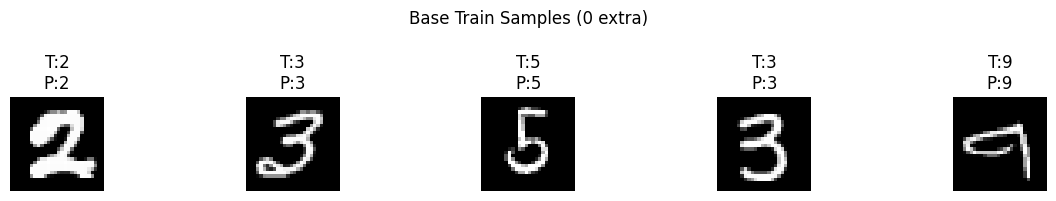

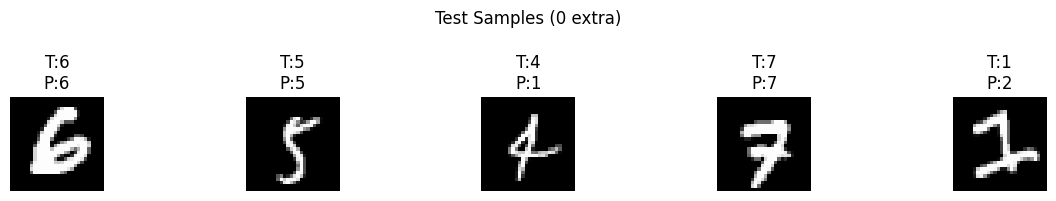

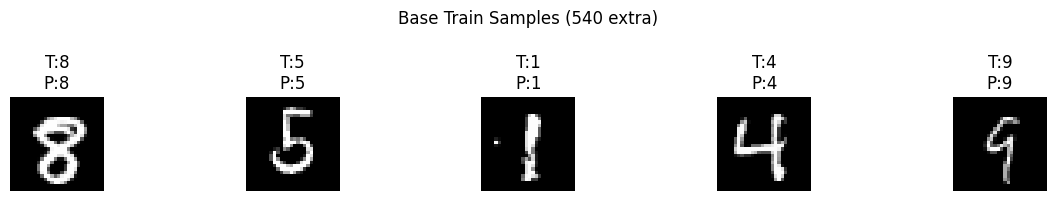

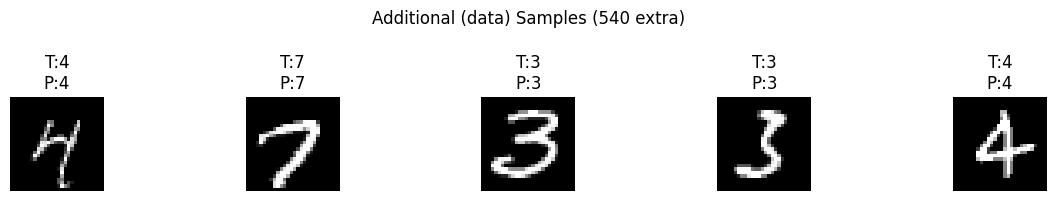

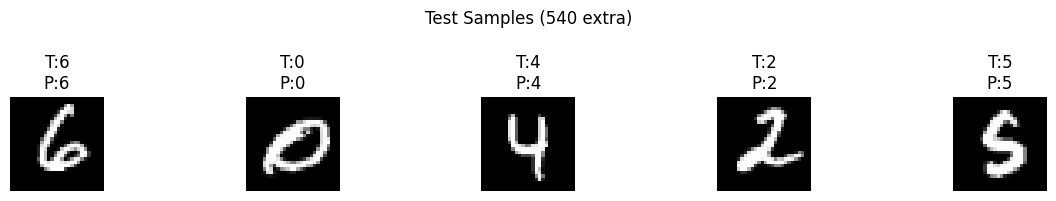

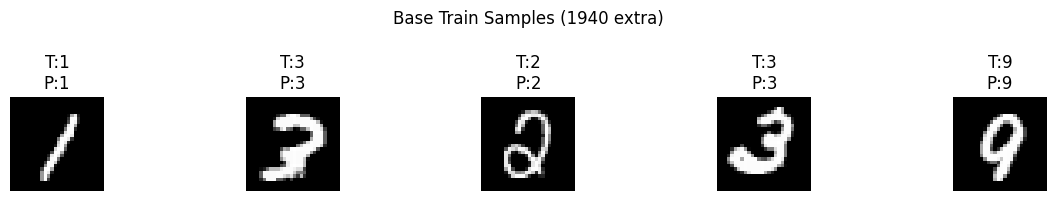

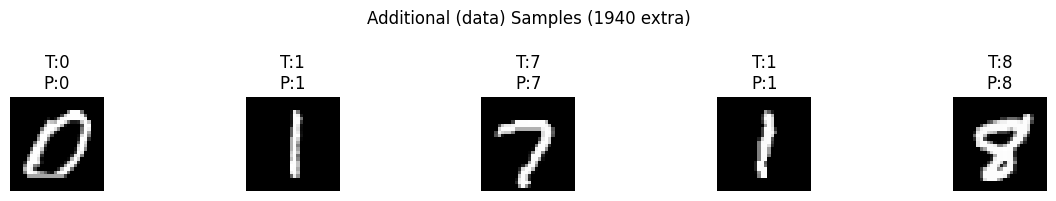

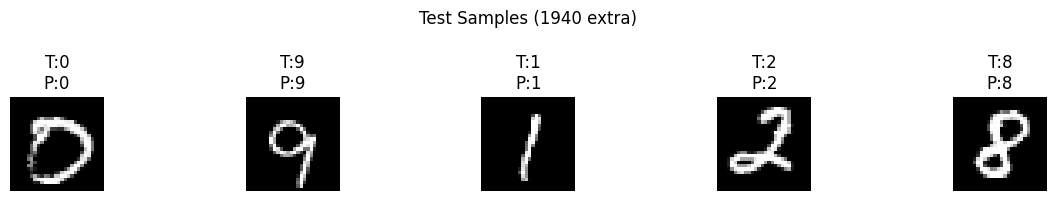

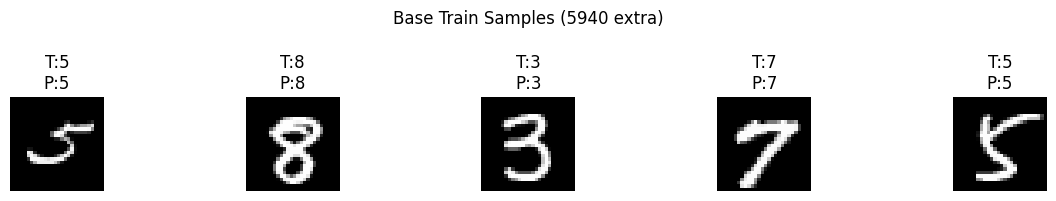

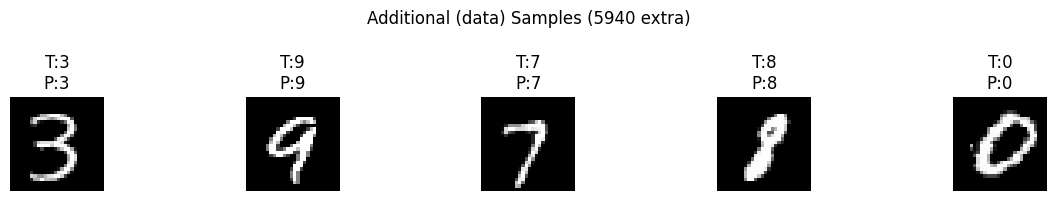

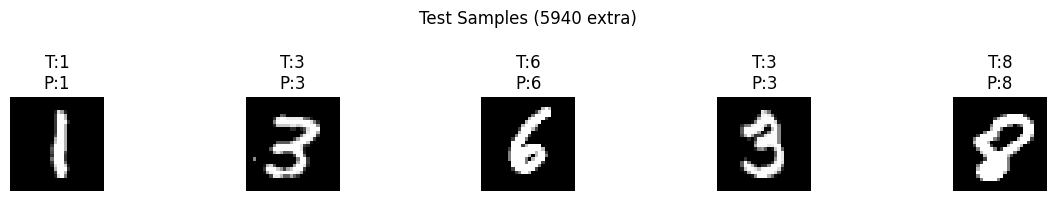

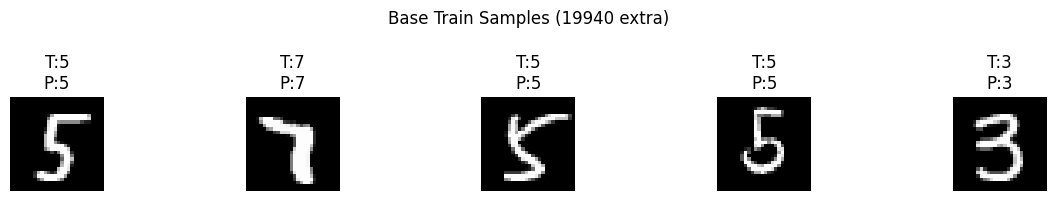

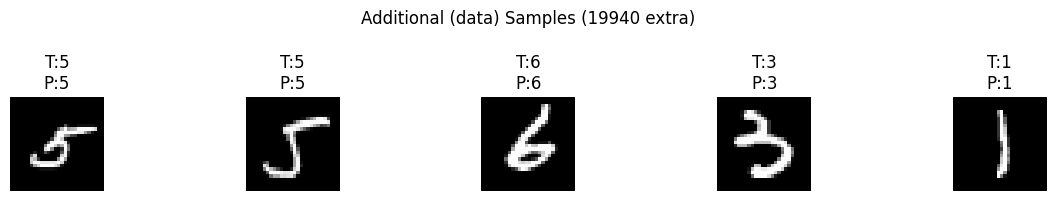

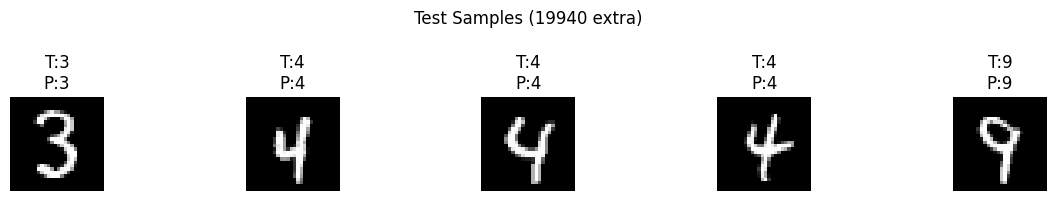

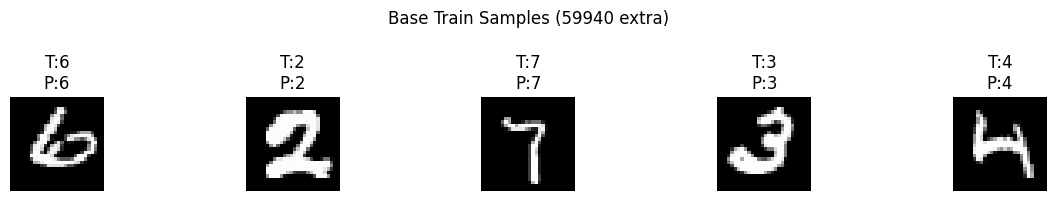

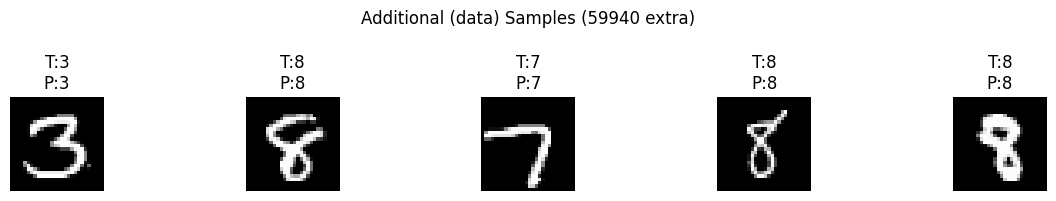

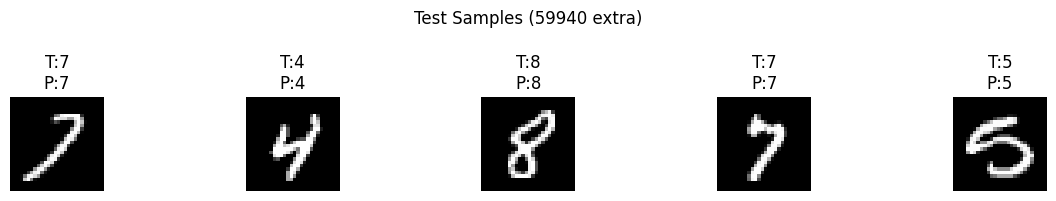

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
